<a href="https://colab.research.google.com/github/siquette/mba_arrumado/blob/main/gwr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import libpysal
import matplotlib.pyplot as plt
import pandas as pd
from esda.moran import Moran
from splot.esda import moran_scatterplot
from google.colab import drive


In [2]:
# 1. Carregar os Shapefiles
try:
    drogas_path = "/content/h3_drogas_agregado.shp"
    roubos_path = "/content/h3_roubo_agregado.shp"

    drogas = gpd.read_file(drogas_path)
    roubos = gpd.read_file(roubos_path)

    print("Shapefiles carregados com sucesso!")

except Exception as e:
    print(f"Erro ao carregar os shapefiles: {e}")
    exit()


Shapefiles carregados com sucesso!


In [3]:

# 2. Verificar e Projetar os CRSs
print("CRS do shapefile de drogas:", drogas.crs)
print("CRS do shapefile de roubos:", roubos.crs)

try:
    crs_alvo = "EPSG:31983"

    if drogas.crs != crs_alvo:
        drogas = drogas.to_crs(crs_alvo)
        print("Shapefile de drogas projetado para EPSG:31983")

    if roubos.crs != crs_alvo:
        roubos = roubos.to_crs(crs_alvo)
        print("Shapefile de roubos projetado para EPSG:31983")

except Exception as e:
    print(f"Erro ao projetar os shapefiles: {e}")
    exit()


CRS do shapefile de drogas: EPSG:4326
CRS do shapefile de roubos: EPSG:4326
Shapefile de drogas projetado para EPSG:31983
Shapefile de roubos projetado para EPSG:31983


In [4]:
# 3. Juntar os dados
try:
    # Renomear colunas para evitar conflitos após a junção
    drogas = drogas.rename(columns={'contagem': 'contagem_drogas'})
    roubos = roubos.rename(columns={'contagem': 'contagem_roubos'})

    # Juntar os GeoDataFrames com base no índice H3
    dados_combinados = roubos.merge(drogas, on='h3_index')

    # Definir a coluna 'geometry' após a junção
    dados_combinados['geometry'] = dados_combinados['geometry_x']

    # Verificar se a junção foi bem-sucedida
    print("Junção dos dados realizada com sucesso!")
    print(dados_combinados.head())

except Exception as e:
    print(f"Erro ao juntar os dados: {e}")
    exit()

Junção dos dados realizada com sucesso!
          h3_index  contagem_roubos  \
0  88a8100c01fffff              751   
1  88a8100c03fffff             1176   
2  88a8100c05fffff              193   
3  88a8100c07fffff              890   
4  88a8100c09fffff              143   

                                          geometry_x  contagem_drogas  \
0  POLYGON ((333828.454 7393096.584, 333310.817 7...               56   
1  POLYGON ((333214.789 7393800.127, 332697.134 7...               83   
2  POLYGON ((334767.726 7393230.083, 334250.085 7...                2   
3  POLYGON ((334154.08 7393933.642, 333636.421 73...               48   
4  POLYGON ((333502.861 7392259.607, 332985.248 7...                6   

                                          geometry_y  \
0  POLYGON ((333828.454 7393096.584, 333310.817 7...   
1  POLYGON ((333214.789 7393800.127, 332697.134 7...   
2  POLYGON ((334767.726 7393230.083, 334250.085 7...   
3  POLYGON ((334154.08 7393933.642, 333636.421 73...   
4  POL

In [5]:
# 4. Preparar os Dados para GWR
try:
    # Variável dependente: contagem de roubos
    y = dados_combinados['contagem_roubos'].values.reshape((-1, 1))

    # Variável independente: contagem de drogas
    X = dados_combinados[['contagem_drogas']].values

    # Adicionar uma coluna de 1s para o intercepto
    X = np.hstack([np.ones(y.shape), X])

    # Coordenadas dos centroides dos hexágonos
    coords = list(zip(dados_combinados['geometry'].centroid.x, dados_combinados['geometry'].centroid.y))

    print("Dados preparados com sucesso para a análise GWR!")

except Exception as e:
    print(f"Erro ao preparar os dados: {e}")
    exit()


Dados preparados com sucesso para a análise GWR!


In [6]:
# 5. Selecionar a Largura de Banda
try:
    # Selecionar a largura de banda usando validação cruzada
    sel_bw = Sel_BW(coords, y, X, kernel='gaussian')
    bw = sel_bw.search()

    print(f"Largura de banda ideal: {bw}")

except Exception as e:
    print(f"Erro ao selecionar a largura de banda: {e}")
    exit()


Largura de banda ideal: 47.0


In [7]:
# 6. Executar a GWR
try:
    # Executar a GWR com a largura de banda otimizada
    gwr_model = GWR(coords, y, X, bw, kernel='gaussian')
    gwr_results = gwr_model.fit()

    print(gwr_results.summary())

except Exception as e:
    print(f"Erro ao executar a GWR: {e}")
    exit()


Model type                                                         Gaussian
Number of observations:                                                 107
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       13006987.986
Log-likelihood:                                                    -778.213
AIC:                                                               1560.427
AICc:                                                              1562.660
BIC:                                                           13006497.339
R2:                                                                   0.179
Adj. R2:                                                              0.171

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [8]:
# 7. Extrair Resultados e Adicionar ao GeoDataFrame
try:
    # Extrair os coeficientes locais
    local_coeficientes = gwr_results.params

    # Extrair o R-quadrado local (verificar o atributo correto)
    local_r2 = gwr_results.localR2  # Tente usar 'localR2' (com R maiúsculo)

    # Extrair os resíduos
    residuos = gwr_results.resid_response

    # Adicionar os resultados ao GeoDataFrame
    dados_combinados['coef_drogas'] = local_coeficientes[:, 1]  # Coeficiente da droga
    dados_combinados['local_r2'] = local_r2
    dados_combinados['residuos'] = residuos

    print("Resultados extraídos e adicionados ao GeoDataFrame com sucesso!")

except Exception as e:
    print(f"Erro ao extrair e adicionar os resultados: {e}")
    exit()


Resultados extraídos e adicionados ao GeoDataFrame com sucesso!


In [9]:
print(dir(gwr_results))

['CCT', 'D2', 'ENP', 'R2', 'RSS', 'S', 'TSS', 'W', 'X', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_get_robustcov_results', 'adj_D2', 'adj_R2', 'adj_alpha', 'adj_pseudoR2', 'aic', 'aicc', 'bic', 'bse', 'conf_int', 'cooksD', 'cov_params', 'critical_tval', 'deviance', 'df_model', 'df_resid', 'family', 'filter_tvals', 'fit_params', 'get_bws_intervals', 'global_deviance', 'influ', 'initialize', 'k', 'llf', 'llnull', 'localR2', 'local_collinearity', 'model', 'mu', 'n', 'name_x', 'normalized_cov_params', 'null', 'null_deviance', 'offset', 'pDev', 'params', 'pearson_chi2', 'predictions', 'predy', 'pseudoR2', 'pvalues', 'resid_anscombe', 'resid_deviance', 'resid_pearson',

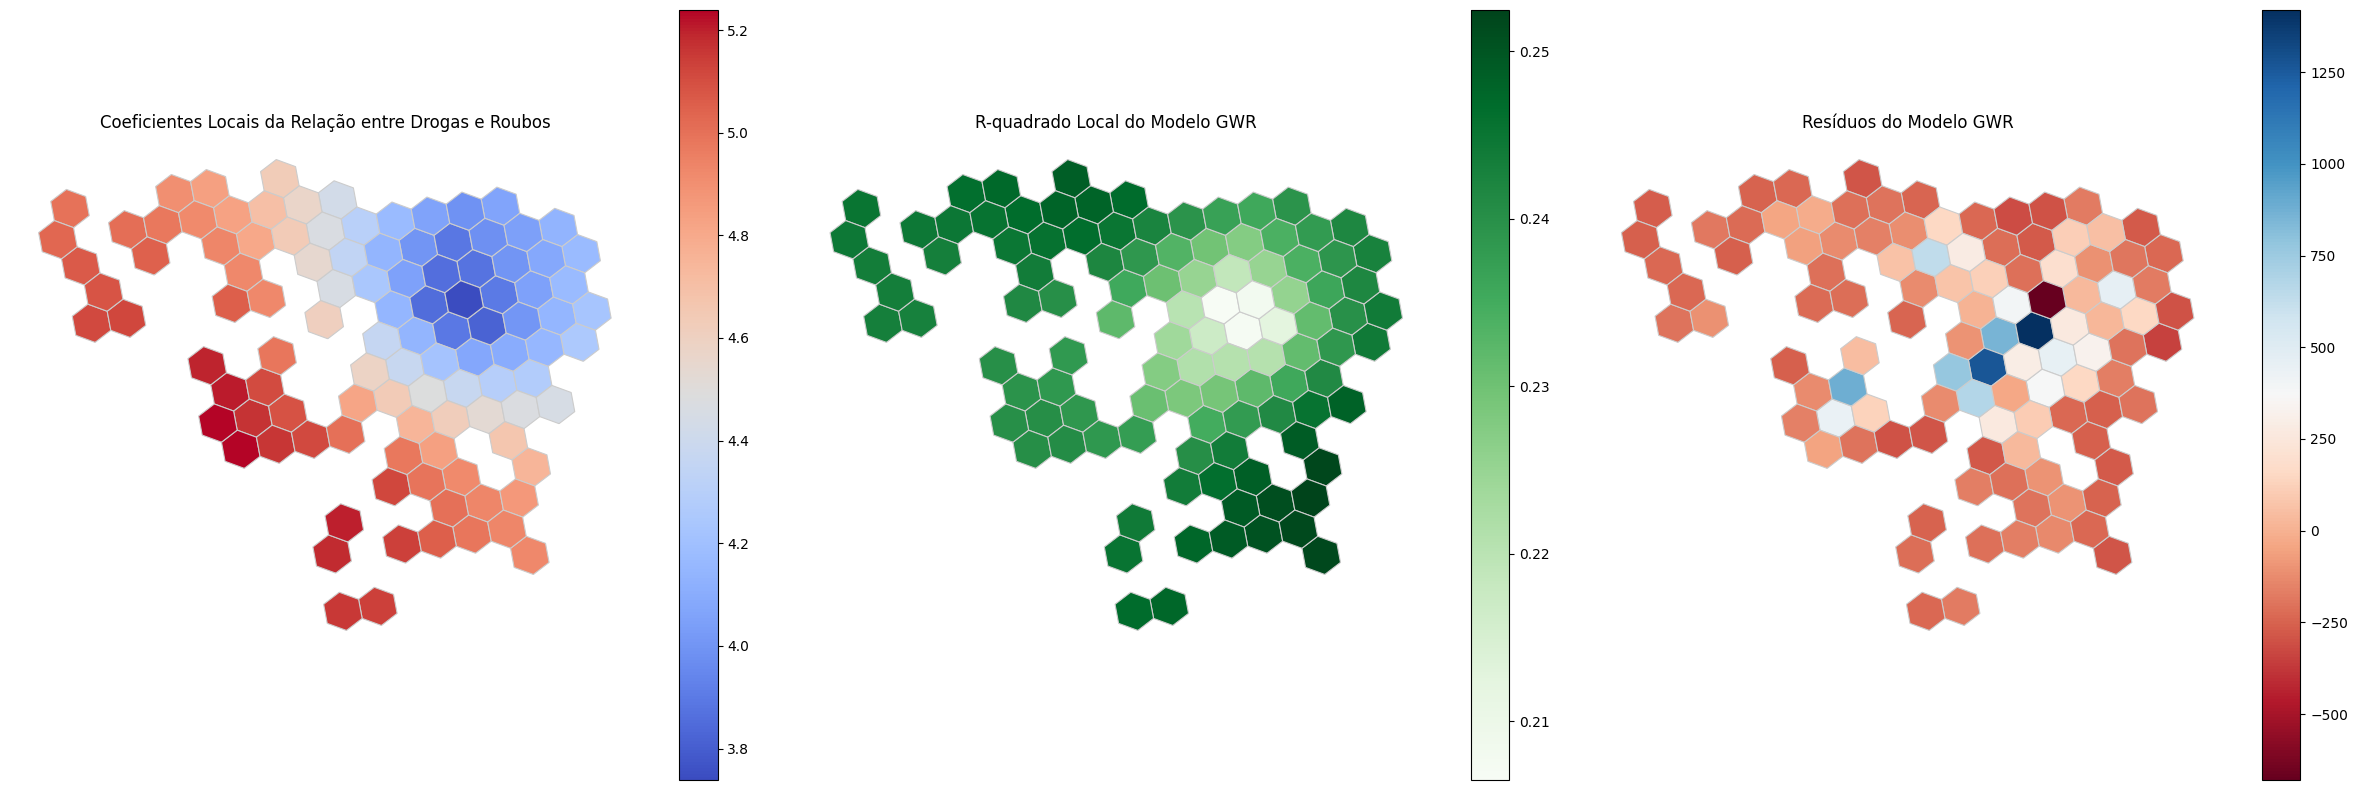

Mapas gerados com sucesso!


In [10]:
# 8. Visualizar os Resultados
try:
    # Configurar a visualização dos mapas
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    axes = axes.flatten()

    # Mapa dos coeficientes locais
    dados_combinados.plot(column='coef_drogas', cmap='coolwarm', linewidth=0.8, ax=axes[0], edgecolor='0.8', legend=True)
    axes[0].set_title("Coeficientes Locais da Relação entre Drogas e Roubos")
    axes[0].axis('off')

    # Mapa do R-quadrado local
    dados_combinados.plot(column='local_r2', cmap='Greens', linewidth=0.8, ax=axes[1], edgecolor='0.8', legend=True)
    axes[1].set_title("R-quadrado Local do Modelo GWR")
    axes[1].axis('off')

    # Mapa dos resíduos
    dados_combinados.plot(column='residuos', cmap='RdBu', linewidth=0.8, ax=axes[2], edgecolor='0.8', legend=True)
    axes[2].set_title("Resíduos do Modelo GWR")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("Mapas gerados com sucesso!")

except Exception as e:
    print(f"Erro ao gerar os mapas: {e}")
    exit()

Índice de Moran: 0.38767748810573543
Valor-p: 0.001


<ipython-input-11-30244a768bc9>:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(dados_combinados)
/usr/local/lib/python3.11/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


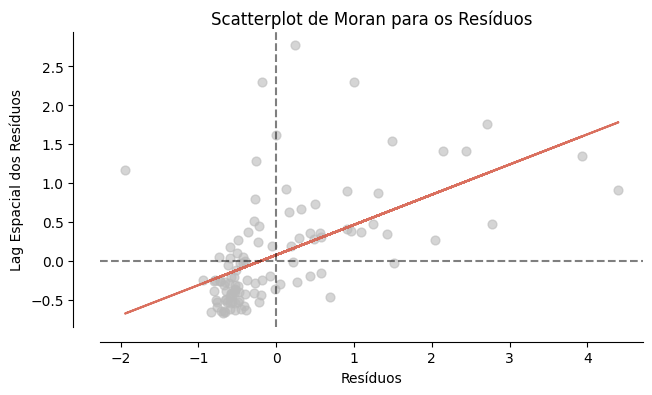

Análise de autocorrelação espacial dos resíduos realizada com sucesso!


In [11]:
# 9. Análise dos Resíduos (Autocorrelação Espacial)
try:
    # Calcular o índice de Moran para os resíduos
    y = dados_combinados['residuos'].values
    w = libpysal.weights.Queen.from_dataframe(dados_combinados)
    w.transform = 'r'
    moran = Moran(y, w)

    print(f"Índice de Moran: {moran.I}")
    print(f"Valor-p: {moran.p_sim}")

    # Gerar o scatterplot de Moran
    moran_scatterplot(moran, aspect_equal=True)
    plt.xlabel('Resíduos')
    plt.ylabel('Lag Espacial dos Resíduos')
    plt.title('Scatterplot de Moran para os Resíduos')
    plt.show()

    print("Análise de autocorrelação espacial dos resíduos realizada com sucesso!")

except Exception as e:
    print(f"Erro ao analisar a autocorrelação espacial dos resíduos: {e}")
    exit()

In [12]:
# 10. Salvar os Resultados em um Shapefile
try:
    # Caminho para salvar o novo shapefile (ajuste o caminho conforme necessário)
    output_path = '/content/drive/My Drive/pasta_dos_shapefiles/gwr_results.shp'

    # Salvar o GeoDataFrame como um shapefile
    dados_combinados.to_file(output_path, driver='ESRI Shapefile')

    print(f"Resultados salvos com sucesso em: {output_path}")

except Exception as e:
    print(f"Erro ao salvar os resultados em um shapefile: {e}")
    exit()

Erro ao salvar os resultados em um shapefile: GeoDataFrame contains multiple geometry columns but GeoDataFrame.to_file supports only a single geometry column. Use a GeoDataFrame.to_parquet or GeoDataFrame.to_feather, drop additional geometry columns or convert them to a supported format like a well-known text (WKT) using `GeoSeries.to_wkt()`.


<ipython-input-12-15aae5761e76>:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dados_combinados.to_file(output_path, driver='ESRI Shapefile')
